In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from parameters import *
from lib.utils import *

Using TensorFlow backend.


In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)

In [5]:
from keras.models import load_model

model = load_model('test_cnn_mnist.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [6]:
def get_angle(x):
    """
    Find 'similarity' of all members in x
    Define as <x1,x2> / (||x1||*||x2||)
    """
    
    len_x = len(x)
    diff = []
    for j in range(len_x):
        for k in range(len_x):
            if j != k:
                tmp = (np.dot(x[j].flatten(), x[k].flatten()) / 
                    (np.linalg.norm(x[j]) * np.linalg.norm(x[k])))
                diff.append(tmp)
    return np.array(diff)

def get_loss(x, y_s, y_t):
    
    len_x = len(x)
    loss_s = np.zeros((len_x,))
    loss_t = np.zeros((len_x,))

    for j in range(len_x):
        x_cur = x_rnd[j].reshape((1,) + INPUT_SHAPE)
        loss_s[j] = model.evaluate(x_cur, y_s.reshape(1, 10), verbose=0)[0]
        loss_t[j] = model.evaluate(x_cur, y_t.reshape(1, 10), verbose=0)[0]
        
    return loss_s, loss_t

Test with `rnd_pgd`  
Pick one sample and one target label, repeatedly initialize a random point in a ball centered at the chosen sample. Perform projected gradient descent for a certain number of steps.

In [ ]:
i = 4
test_len = 1000
y_t = np.array([0])
y_t = keras.utils.to_categorical(y_t, NUM_LABELS)

x_rnd = np.zeros((test_len,) + INPUT_SHAPE)

for j in range(test_len):
    tmp = rnd_pgd(model, x_test[i].reshape((1,) + INPUT_SHAPE), y_t, 
                  norm="inf", n_step=40, step_size=0.01, target=True, init_rnd=0.1)
    x_rnd[j] = tmp

In [7]:
loss_s, loss_t = get_loss(x_rnd, y_test[i], y_t)

Histogram of loss with respect to the target label

(array([ 763.,   52.,   43.,   28.,   13.,    8.,    7.,    9.,    3.,
           3.,    4.,    2.,    1.,    3.,    5.,    0.,    1.,    4.,
           6.,    5.,    5.,    3.,    4.,    3.,    8.,    6.,    4.,
           2.,    2.,    3.]),
 array([  1.16825786e-05,   3.11945955e-01,   6.23880227e-01,
          9.35814500e-01,   1.24774877e+00,   1.55968304e+00,
          1.87161732e+00,   2.18355159e+00,   2.49548586e+00,
          2.80742013e+00,   3.11935441e+00,   3.43128868e+00,
          3.74322295e+00,   4.05515722e+00,   4.36709150e+00,
          4.67902577e+00,   4.99096004e+00,   5.30289431e+00,
          5.61482859e+00,   5.92676286e+00,   6.23869713e+00,
          6.55063140e+00,   6.86256568e+00,   7.17449995e+00,
          7.48643422e+00,   7.79836849e+00,   8.11030277e+00,
          8.42223704e+00,   8.73417131e+00,   9.04610558e+00,
          9.35803986e+00]),
 <a list of 30 Patch objects>)

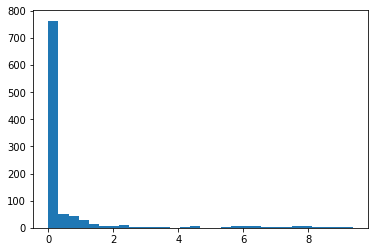

In [8]:
plt.hist(loss_t, bins=30)

Calculate the angle between all pairs of adversarial examples generated

In [9]:
diff = get_angle(x_rnd)

In [11]:
np.mean(diff)

0.89698024003700838

(array([  8.00000000e+00,   2.00000000e+01,   1.16000000e+02,
          2.80000000e+02,   6.38000000e+02,   1.52400000e+03,
          2.87800000e+03,   5.16200000e+03,   7.92000000e+03,
          1.13540000e+04,   1.58940000e+04,   2.08660000e+04,
          2.60860000e+04,   3.34420000e+04,   4.37380000e+04,
          5.66060000e+04,   7.21360000e+04,   8.83780000e+04,
          1.02178000e+05,   1.12102000e+05,   1.10002000e+05,
          9.89480000e+04,   7.78060000e+04,   5.41400000e+04,
          3.18040000e+04,   1.57640000e+04,   6.60400000e+03,
          2.09600000e+03,   4.62000000e+02,   4.80000000e+01]),
 array([ 0.80075926,  0.8059307 ,  0.81110213,  0.81627357,  0.821445  ,
         0.82661643,  0.83178787,  0.8369593 ,  0.84213074,  0.84730217,
         0.8524736 ,  0.85764504,  0.86281647,  0.86798791,  0.87315934,
         0.87833077,  0.88350221,  0.88867364,  0.89384508,  0.89901651,
         0.90418795,  0.90935938,  0.91453081,  0.91970225,  0.92487368,
         0.93

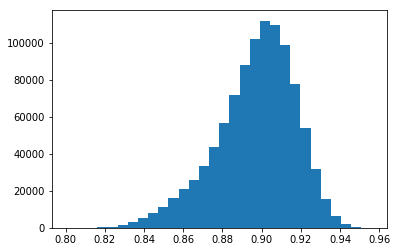

In [12]:
plt.hist(diff, bins=30)

Test `s_pgd`  

In [7]:
i = 4
test_len = 1000
y_t = np.array([0])
y_t = keras.utils.to_categorical(y_t, NUM_LABELS)

x_rnd = np.zeros((test_len,) + INPUT_SHAPE)

for j in range(test_len):
    if j % 100 == 0:
        print(j)
    tmp = s_pgd(model, x_test[i].reshape((1,) + INPUT_SHAPE), y_t,  
                norm="inf", n_step=40, step_size=0.01, 
                target=True, beta=0.2, early_stop=True)
    x_rnd[j] = tmp

0
100
200
300
400
500
600
700
800
900


In [29]:
diff = get_angle(x_rnd)

(array([  20.,   28.,   86.,  156.,  122.,  116.,  218.,  240.,  208.,
         212.,  284.,  276.,  268.,  282.,  374.,  346.,  320.,  372.,
         366.,  392.,  408.,  416.,  452.,  478.,  498.,  514.,  534.,
         552.,  600.,  762.]),
 array([ 0.99999938,  0.9999994 ,  0.99999942,  0.99999944,  0.99999946,
         0.99999948,  0.9999995 ,  0.99999952,  0.99999954,  0.99999956,
         0.99999958,  0.9999996 ,  0.99999962,  0.99999964,  0.99999966,
         0.99999969,  0.99999971,  0.99999973,  0.99999975,  0.99999977,
         0.99999979,  0.99999981,  0.99999983,  0.99999985,  0.99999987,
         0.99999989,  0.99999991,  0.99999993,  0.99999995,  0.99999997,
         0.99999999]),
 <a list of 30 Patch objects>)

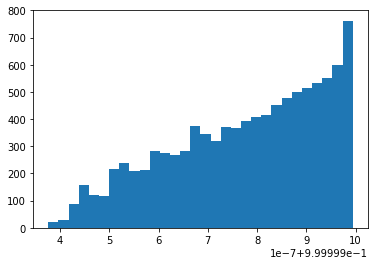

In [17]:
# step_size, beta = 0.01, 0.01
plt.hist(diff, bins=30)

(array([  58252.,   12096.,    5934.,    4510.,    5304.,    4010.,
           3890.,    3864.,    5242.,    4054.,    3834.,    7130.,
           5566.,    5568.,    4682.,    4950.,    5632.,    5734.,
           7246.,    8878.,    7556.,    8914.,    7922.,    9542.,
          12252.,   12878.,   16210.,   17502.,   24000.,  715848.]),
 array([ 0.52218308,  0.53811029,  0.5540375 ,  0.56996472,  0.58589193,
         0.60181914,  0.61774635,  0.63367356,  0.64960077,  0.66552798,
         0.68145519,  0.6973824 ,  0.71330962,  0.72923683,  0.74516404,
         0.76109125,  0.77701846,  0.79294567,  0.80887288,  0.82480009,
         0.8407273 ,  0.85665451,  0.87258173,  0.88850894,  0.90443615,
         0.92036336,  0.93629057,  0.95221778,  0.96814499,  0.9840722 ,
         0.99999941]),
 <a list of 30 Patch objects>)

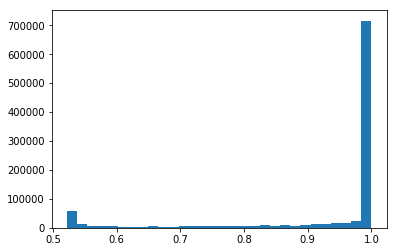

In [12]:
# step_size, beta = 0.01, 0.1
plt.hist(diff, bins=30)

(array([  20.,   64.,   94.,  108.,   88.,   96.,   70.,  122.,  112.,
         162.,  200.,  262.,  310.,  304.,  324.,  338.,  356.,  400.,
         398.,  412.,  422.,  456.,  504.,  508.,  548.,  562.,  596.,
         620.,  648.,  796.]),
 array([ 0.99998304,  0.9999836 ,  0.99998416,  0.99998472,  0.99998528,
         0.99998584,  0.9999864 ,  0.99998696,  0.99998752,  0.99998808,
         0.99998864,  0.9999892 ,  0.99998976,  0.99999032,  0.99999088,
         0.99999144,  0.999992  ,  0.99999256,  0.99999312,  0.99999368,
         0.99999424,  0.9999948 ,  0.99999537,  0.99999593,  0.99999649,
         0.99999705,  0.99999761,  0.99999817,  0.99999873,  0.99999929,
         0.99999985]),
 <a list of 30 Patch objects>)

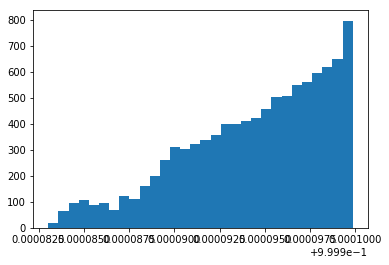

In [20]:
# step_size, beta = 0.01, 0.05
plt.hist(diff, bins=30)

(array([  18.,   60.,   86.,   76.,   94.,  102.,  132.,  124.,  158.,
         230.,  184.,  244.,  254.,  282.,  330.,  330.,  340.,  364.,
         398.,  406.,  418.,  450.,  524.,  546.,  584.,  588.,  610.,
         610.,  600.,  758.]),
 array([ 0.99975551,  0.99976358,  0.99977165,  0.99977972,  0.99978779,
         0.99979586,  0.99980393,  0.999812  ,  0.99982007,  0.99982814,
         0.99983621,  0.99984428,  0.99985235,  0.99986042,  0.99986849,
         0.99987656,  0.99988463,  0.9998927 ,  0.99990077,  0.99990884,
         0.99991691,  0.99992498,  0.99993305,  0.99994111,  0.99994918,
         0.99995725,  0.99996532,  0.99997339,  0.99998146,  0.99998953,
         0.9999976 ]),
 <a list of 30 Patch objects>)

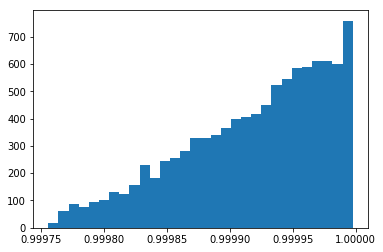

In [32]:
# step_size, beta = 0.01, 0.2
plt.hist(diff, bins=30)

Calculate histogram and variance of angle difference for uniformly random points in \[0, 1\]

Variance:  0.00012455730524


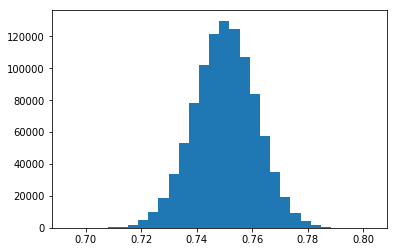

In [10]:
h, w, c = x_test[0].shape
len_rnd = 1000

rnd = np.random.rand(len_rnd, h, w, c)
diff = get_angle(rnd)
plt.hist(diff, bins=30)
print("Variance: ", np.var(diff))

Estimate hyperplane to fit all generated adversarial examples

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=783)
x_flat = x_rnd.reshape((-1, 784))
pca.fit(x_flat - np.mean(x_flat, axis=0))

PCA(copy=True, iterated_power='auto', n_components=783, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
proj_matrix = np.dot(pca.components_.T, pca.components_)

In [25]:
x_tran = np.dot(x_flat, proj_matrix)

In [30]:
np.linalg.norm(x_tran - x_test[i].reshape(1, 784), axis=1)

array([ 24.98604252,  25.05317965,  25.0199372 ,  24.93819245,
        24.96798254,  24.99102437,  24.92680263,  24.90112348,
        24.85826027,  24.94667539,  24.87636001,  24.90693064,
        24.96553104,  24.91922073,  24.97049527,  24.92012705,
        24.92881362,  24.93084759,  24.94914866,  24.94345114,
        24.94618758,  24.97085743,  24.88376759,  24.94978845,
        24.8954351 ,  24.85367802,  24.83692556,  24.89698486,
        24.85006905,  24.8353253 ,  24.8280708 ,  24.8573715 ,
        24.88185145,  24.8503544 ,  24.82900321,  24.74299258,
        24.70378048,  24.70670802,  24.6206857 ,  24.58301794,
        24.51860039,  24.45666108,  24.38813176,  24.32053759,
        24.24921284,  24.17992553,  24.11118903,  24.04134236,
        23.97238736,  23.89731016,  23.81316875,  23.72455791,
        23.64669747,  23.55833977,  23.47632359,  23.38377669,
        23.30365079,  23.21746417,  23.13174031,  23.0548939 ,
        22.97151523,  22.89351785,  22.80647353,  22.73

------

In [5]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s - loss: 0.3329 - acc: 0.8986 - val_loss: 0.0811 - val_acc: 0.9740
Epoch 2/12
60000/60000 [==============================] - 3s - loss: 0.1176 - acc: 0.9656 - val_loss: 0.0568 - val_acc: 0.9816
Epoch 3/12
60000/60000 [==============================] - 3s - loss: 0.0885 - acc: 0.9740 - val_loss: 0.0459 - val_acc: 0.9849
Epoch 4/12
60000/60000 [==============================] - 3s - loss: 0.0734 - acc: 0.9774 - val_loss: 0.0405 - val_acc: 0.9863
Epoch 5/12
60000/60000 [==============================] - 3s - loss: 0.0666 - acc: 0.9805 - val_loss: 0.0385 - val_acc: 0.9857
Epoch 6/12
60000/60000 [==============================] - 3s - loss: 0.0582 - acc: 0.9829 - val_loss: 0.0349 - val_acc: 0.9884
Epoch 7/12
60000/60000 [==============================] - 3s - loss: 0.0531 - acc: 0.9842 - val_loss: 0.0323 - val_

In [6]:
model.save('test_cnn_mnist.h5')